In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from tensorflow.compat.v1 import ConfigProto, InteractiveSession

config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 16

CHANNELS = 3
EPOCHS = 250


In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "shoes",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 5 classes.


In [5]:
class_names = dataset.class_names
class_names

['Ballet Flat', 'Boat', 'Brogue', 'Clog', 'Sneaker']

In [6]:
len(dataset)

625

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(16, 256, 256, 3)
[2 1 0 2 4 2 3 2 2 2 2 2 4 1 2 0]


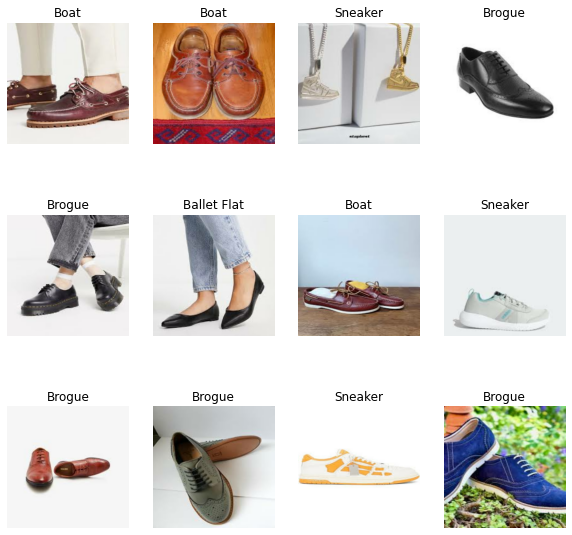

In [8]:
plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis('off')
        plt.title(class_names[label_batch[i]])
    

In [9]:
len(dataset)

625

In [10]:
train_ds = dataset.take(int(0.8*313))
len(train_ds)

250

In [11]:
test_ds = dataset.skip(250)
len(test_ds)

375

In [12]:
val_ds = test_ds.take(31)
len(val_ds)

31

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

369

In [14]:
train_size=0.8
val_size = 0.1

def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=1000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds


In [15]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset)

In [16]:
len(train_ds),len(val_ds),len(test_ds)

(500, 62, 63)

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
    
])

In [19]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [20]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 5
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(32,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(5,5),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(128,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(32,activation='relu'),
    layers.Dense(16,activation='relu'),
    
   
    
    layers.Dense(n_classes,activation='softmax')
    
])


model.build(input_shape=input_shape)


In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (16, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (16, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (16, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (16, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (16, 125, 125, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (16, 62, 62, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (16, 60, 60, 32)         

In [22]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy'],
)

In [23]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/250
500/500 [==============================] - 209s 350ms/step - loss: 1.6098 - accuracy: 0.1964 - val_loss: 1.6092 - val_accuracy: 0.2228
Epoch 2/250
500/500 [==============================] - 88s 176ms/step - loss: 1.6096 - accuracy: 0.2000 - val_loss: 1.6095 - val_accuracy: 0.1774
Epoch 3/250
500/500 [==============================] - 68s 137ms/step - loss: 1.6096 - accuracy: 0.2000 - val_loss: 1.6093 - val_accuracy: 0.1774
Epoch 4/250
204/500 [===========>..................] - ETA: 19s - loss: 1.6094 - accuracy: 0.2053

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history['accuracy']

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(15,15))
# plt.subplot(2,1,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


# plt.subplot(2, 1, 2)
# plt.plot(range(EPOCHS), loss, label='Training Loss')
# plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()


In [ ]:
plt.figure(figsize=(20,15))
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")